In [1]:
import numpy as np
from matplotlib import pyplot as plt
import math
from math import exp, sqrt,pi
import time

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset,RandomSampler

In [2]:

start = 0.
end = 1.

x = np.linspace(start,end,100 )
y = np.linspace(start,end,100)
x, y = np.meshgrid(x, y)
x = np.reshape(x, (np.size(x[:]),1))
y = np.reshape(y, (np.size(y[:]),1))

xb1 = np.linspace(start,start, 100 )
yb1 = np.linspace(start,end, 100 ) 
xb1 = xb1.reshape(-1, 1)
yb1 = yb1.reshape(-1, 1)

xb2 = np.linspace(start,end, 100 )
yb2 = np.linspace(end,end, 100 ) 
xb2 = xb2.reshape(-1, 1)
yb2 = yb2.reshape(-1, 1)

xb3 = np.linspace(end,end, 100 )
yb3 = np.linspace(start,end, 100 ) 
xb3 = xb3.reshape(-1, 1)
yb3 = yb3.reshape(-1, 1)

xb4 = np.linspace(start,end, 100 )
yb4 = np.linspace(start,start, 100 ) 
xb4 = xb4.reshape(-1, 1)
yb4 = yb4.reshape(-1, 1)

xb = [xb1,xb2,xb3,xb4]
yb = [yb1,yb2,yb3,yb4]

def actual_soln(eps):
    p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
    return (np.sin(np.pi*x) + (eps*np.pi/p)*(np.exp(-x/eps) + np.exp((x-1)/eps) - q) ) * (2*y*(1 - y**2) + eps * ( p*d*(1-2*y) - 3*q/p + (3/p - d)*np.exp(-y/eps) + (3/p + d)*np.exp((y-1)/eps)))


In [3]:
def plot_graph(soln,soln_name):
    x = np.linspace(start,end,100);y = np.linspace(start,end,100)
    x,y = np.meshgrid(x,y)
    ax = plt.axes(projection='3d')
    ax.plot_surface(x,y,soln.reshape(100,100))
    plt.title(soln_name)
    plt.show()

class Swish(nn.Module):
	def __init__(self, inplace=True):
		super(Swish, self).__init__()
		self.inplace = inplace

	def forward(self, x):
		if self.inplace:
			x.mul_(torch.sigmoid(x))
			return x
		else:
			return x * torch.sigmoid(x)
	

class PINN(nn.Module):
	hid_dim = 128
	input_dim = 2 
	def __init__(self):
		super(PINN, self).__init__()
		self.tanh = nn.Tanh()
		self.lin0 = nn.Linear(self.input_dim,self.hid_dim)
		self.lin = nn.Linear(self.hid_dim,self.hid_dim)
		self.lin1 = nn.Linear(self.hid_dim,1)
		self.swish = Swish()
	def forward(self,x):		
		x = self.lin0(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin(x)
		x = self.swish(x)
		x = self.lin1(x)
		return x


In [4]:
def train(device,x,y,xb,yb,eps,learning_rate,epochs,batch_flag,batch_size):
	xnet = torch.Tensor(x).to(device)
	ynet = torch.Tensor(y).to(device) 
	xb1,xb2,xb3,xb4 = xb
	yb1,yb2,yb3,yb4 = yb
	xb1 = torch.Tensor(xb1).to(device) 	
	yb1 = torch.Tensor(yb1).to(device) 
	xb2 = torch.Tensor(xb2).to(device) 	
	yb2 = torch.Tensor(yb2).to(device) 
	xb3 = torch.Tensor(xb3).to(device) 	
	yb3 = torch.Tensor(yb3).to(device) 
	xb4 = torch.Tensor(xb4).to(device) 	
	yb4 = torch.Tensor(yb4).to(device) 

	if(batch_flag):
		dataset = TensorDataset(xnet,ynet)
		dataloader = DataLoader(dataset, batch_size=batch_size,shuffle=True,num_workers = 0,drop_last = True )
	
	net = PINN().to(device)
	
	def init_normal(m):
		if type(m) == nn.Linear:
			nn.init.kaiming_normal_(m.weight)

	net.apply(init_normal)

	optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)

	def Loss_criterion(xnet,ynet):
		xnet.requires_grad = True
		ynet.requires_grad = True
		points = torch.cat((xnet,ynet),1) 
		U = net(points)

		U = U.view(len(U),-1)

		p = 1 - np.exp(-1/eps);q = 1 + np.exp(-1/eps);d = 1/(q - 2*eps*p)
		
		soln = (torch.sin(np.pi*xnet) + (eps*np.pi/p)*(torch.exp(-xnet/eps) + torch.exp((xnet-1)/eps) - q) ) * (2*ynet*(1 - ynet*ynet) + eps * ( p*d*(1-2*ynet) - 3*q/p + (3/p - d)*torch.exp(-ynet/eps) + (3/p + d)*torch.exp((ynet-1)/eps)))
		
		soln_x = torch.autograd.grad(soln,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xx = torch.autograd.grad(soln_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxx = torch.autograd.grad(soln_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_xxxx = torch.autograd.grad(soln_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		soln_y = torch.autograd.grad(soln,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yy = torch.autograd.grad(soln_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyy = torch.autograd.grad(soln_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_yyyy = torch.autograd.grad(soln_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxy = torch.autograd.grad(soln_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		soln_xxyy = torch.autograd.grad(soln_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]

		f = (eps**2)*(soln_xxxx + soln_yyyy + 2*soln_xxyy) - (soln_xx + soln_yy)

		U_x = torch.autograd.grad(U,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xx = torch.autograd.grad(U_x,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxx = torch.autograd.grad(U_xx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_xxxx = torch.autograd.grad(U_xxx,xnet,grad_outputs=torch.ones_like(xnet),create_graph = True,only_inputs=True)[0]
		U_y = torch.autograd.grad(U,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yy = torch.autograd.grad(U_y,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyy = torch.autograd.grad(U_yy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_yyyy = torch.autograd.grad(U_yyy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxy = torch.autograd.grad(U_xx,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		U_xxyy = torch.autograd.grad(U_xxy,ynet,grad_outputs=torch.ones_like(ynet),create_graph = True,only_inputs=True)[0]
		loss1 = (eps**2)*(U_xxxx + U_yyyy + 2*U_xxyy) - (U_xx + U_yy) - f 
		return nn.MSELoss()(loss1,torch.zeros_like(loss1)) 

	def Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4):
		
		xb1.requires_grad = True
		yb1.requires_grad = True
		xb2.requires_grad = True
		yb2.requires_grad = True
		xb3.requires_grad = True
		yb3.requires_grad = True
		xb4.requires_grad = True
		yb4.requires_grad = True
	
		loss_f = nn.MSELoss()


		net1 = torch.cat((xb1, yb1), 1)
		out1 = net(net1)
		ub1 = out1.view(len(out1), -1)
		der_ub1 = torch.autograd.grad(ub1,xb1,grad_outputs=torch.ones_like(xb1),create_graph = True,only_inputs=True)[0]

		loss_dirichlet1 = loss_f(ub1,torch.zeros_like(ub1))
		loss_neumann1 = loss_f(der_ub1,torch.zeros_like(der_ub1))

		net2 = torch.cat((xb2, yb2), 1)
		out2 = net(net2)
		ub2 = out2.view(len(out2), -1)
		der_ub2 = torch.autograd.grad(ub2,yb2,grad_outputs=torch.ones_like(yb2),create_graph = True,only_inputs=True)[0]

		loss_dirichlet2 = loss_f(ub2,torch.zeros_like(ub2))
		loss_neumann2 = loss_f(der_ub2,torch.zeros_like(der_ub2))

		net3 = torch.cat((xb3, yb3), 1)
		out3 = net(net3)
		ub3 = out3.view(len(out3), -1)
		der_ub3 = torch.autograd.grad(ub3,xb3,grad_outputs=torch.ones_like(xb3),create_graph = True,only_inputs=True)[0]

		loss_dirichlet3 = loss_f(ub3,torch.zeros_like(ub3))
		loss_neumann3 = loss_f(der_ub3,torch.zeros_like(der_ub3))

		net4 = torch.cat((xb4, yb4), 1)
		out4 = net(net4)
		ub4 = out4.view(len(out4), -1)
		der_ub4 = torch.autograd.grad(ub4,yb4,grad_outputs=torch.ones_like(yb4),create_graph = True,only_inputs=True)[0]

		loss_dirichlet4 = loss_f(ub4,torch.zeros_like(ub4))
		loss_neumann4 = loss_f(der_ub4,torch.zeros_like(der_ub4))

		total_loss = loss_dirichlet1 + loss_neumann1 + loss_dirichlet2 + loss_neumann2 + loss_dirichlet3 + loss_neumann3 + loss_dirichlet4 + loss_neumann4 
		return total_loss

	losses = []
	tic = time.time()


	if(batch_flag):
		for epoch in range(epochs):
			if epoch == 40:
				learning_rate = 0.0001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer
			for batch_idx, (x_in,y_in) in enumerate(dataloader):

				net.zero_grad()
				loss_eqn = Loss_criterion(x_in,y_in)
				loss_bc = Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
				loss = loss_eqn + loss_bc
				loss.backward()

				optimizer.step() 
				if batch_idx % 20 ==0:
					print('Train Epoch: {} \nTotal Loss: {:.10f} \tCriterion Loss: {:.10f} \tBoundary Condition Loss {:.6f}'.format(
					epoch, loss.item(),loss_eqn.item(),loss_bc.item()))

			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			print('\nAfter Epoch {}, \t Actual solution loss: {:.10f}\n'.format(
				epoch, actual_loss))
			if epoch % 1 == 0:
				plot_graph(z,'Predicted solution')
			
			losses.append([loss.item(),actual_loss])
	else:
		for epoch in range(epochs):
			if epoch == 100:
				learning_rate = 0.0001
				new_optimizer = optim.Adam(net.parameters(), lr=learning_rate, betas = (0.9,0.99),eps = 10**-15)
				optimizer = new_optimizer

			net.zero_grad()
			loss_eqn = Loss_criterion(xnet,ynet)
			loss_bc = Loss_BC(xb1,xb2,xb3,xb4,yb1,yb2,yb3,yb4)
			loss = loss_eqn + loss_bc
			loss.backward()
			
			optimizer.step() 
			points = torch.cat((xnet,ynet),1)
			U = net(points)
			z = U.detach().numpy()
			actual_loss = np.square(actual_soln(eps) - z).mean()
			if epoch % 5 == 0:
				plot_graph(z,"soln")
			print('Train Epoch: {} \nTotal Loss: {:.10f} \tCriterion Loss: {:.10f} \tBoundary Condition Loss {:.6f}\nActual loss: {:.6f}'.format(
				epoch, loss.item(),loss_eqn.item(),loss_bc.item(),actual_loss))
			losses.append([loss.item(),loss_eqn.item(),loss_bc.item(),actual_loss])

	toc = time.time()
	elapseTime = toc - tic
	print ("elapse time in parallel = ", elapseTime)

	net_in = torch.cat((xnet,ynet),1)
	output = net(net_in)  
	
	return output 

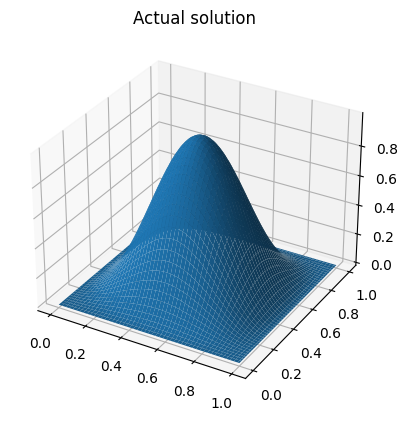

In [6]:
eps = 1
plot_graph(actual_soln(eps),'Actual solution')

Train Epoch: 0 
Total Loss: 857346.4375000000 	Criterion Loss: 857344.6875000000 	Boundary Condition Loss 1.732670
Train Epoch: 0 
Total Loss: 257908.7031250000 	Criterion Loss: 257798.1562500000 	Boundary Condition Loss 110.542168
Train Epoch: 0 
Total Loss: 45474.7187500000 	Criterion Loss: 45366.4960937500 	Boundary Condition Loss 108.223694
Train Epoch: 0 
Total Loss: 9585.2382812500 	Criterion Loss: 9540.6640625000 	Boundary Condition Loss 44.574635

After Epoch 0, 	 Actual solution loss: 1.5914781824



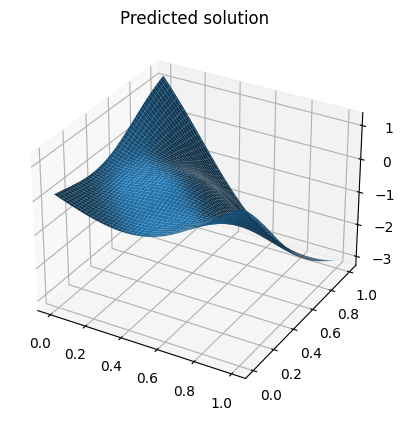

Train Epoch: 1 
Total Loss: 2179.5722656250 	Criterion Loss: 2144.1787109375 	Boundary Condition Loss 35.393475


In [7]:
epochs = 1000
device = torch.device("cpu")

batchsize = 128 
learning_rate = 1e-3
batch_flag = True
batch_size = 128

output = train(device,x,y,xb,yb,eps,learning_rate,epochs,batch_flag,batch_size)

In [1]:
z = output.detach().numpy()
plot_graph(z,"Predicted Solution")
plot_graph(actual_soln(eps),"Actual Solution")

NameError: name 'output' is not defined